In [1]:
import pandas as pd
import sklearn
import numpy as np
import sys
sys.path.append('../utils/')

from sklearn.cluster import DBSCAN
from sklearn import metrics

from series_plot import plot_multi_series
from computation import *
from processing import *

# Data preprocessing


In [2]:
# read data 
data = pd.read_excel('../data/sample data SR99.xlsx')
keys = data.keys()


In [3]:
# check nan
nan_sum = data.isna().sum()
incomplete_col = nan_sum[nan_sum != 0]
incomplete_col_ratio = incomplete_col/len(data)
# print (incomplete_col_ratio)

print ("len of series : %d " %len(data))
print ("len of parameters : %d " %len(keys))
print ("number of columns with missing values : %d " %len(incomplete_col))
print ("average number of missing values : %d " %incomplete_col.mean())
print ("mean missing ratio : %f " %incomplete_col_ratio.mean())
print ("max missing values : %d " %incomplete_col.max())
print ("max missing ratio : %f " %incomplete_col_ratio.max())

len of series : 1416 
len of parameters : 5975 
number of columns with missing values : 3292 
average number of missing values : 147 
mean missing ratio : 0.103995 
max missing values : 1416 
max missing ratio : 1.000000 


In [4]:
# remove columns with high missing ratio
rem_thre = 0.4
bad_column = incomplete_col_ratio[incomplete_col_ratio > rem_thre]
bad_keys = bad_column.keys()
print (bad_column)


[401] [TPC]                                 1.000000
[403] [TPC]                                 1.000000
[408] [TPC]                                 1.000000
[2182]                                      1.000000
[2183]                                      1.000000
[3328]                                      1.000000
[3495] [TPC]                                1.000000
[3593]                                      1.000000
[5840] No.1 TAIL SEAL(A) PU.RUNNING TIME    0.624294
[5841] No.2 TAIL SEAL(B) PU.RUNNING TIME    0.624294
[6027] No.3 TAIL SEAL(C) PU.RUNNING TIME    0.624294
[6028] HBW 1(CUTTER)PU.RUNNING TIME         0.611582
[6029] HBW 2 PU.RUNNING TIME                0.611582
[6030] HBW 3(AGITATOR)PU.RUNNING TIME       0.624294
dtype: float64


In [5]:
# remove the bad columns from data
data = data.drop(bad_keys, axis=1)


In [6]:
# remove time stamps and non value data from the dataset 
keys = data.keys()

inval_keys = []
valid_keys = []
pure_sig_keys = []
for i,k in enumerate(keys):
    if "Date" in k or "Time" in k:
        inval_keys.append(k)
    else: 
        x = np.array(data[k][1:])
        try: 
            x.astype(np.float64)
        except:
            inval_keys.append(k)
            continue
            
        d_min,d_max = x.min(),x.max()
        if (d_min+d_max==1) and (data[k][0]=="on/off") :
            pure_sig_keys.append(k)
            continue
        valid_keys.append(k)
print (len(keys),len(valid_keys),len(inval_keys),len(pure_sig_keys))

5961 4540 148 1273


In [7]:
valid_data = data[valid_keys]
stamp_data = data[inval_keys]
pure_sig_data = data[pure_sig_keys]

# save to file 
valid_data.to_csv('../data/continuous_data.csv')
stamp_data.to_csv('../data/stamp_data.csv')
pure_sig_data.to_csv('../data/pure_sig_data.csv')

In [8]:
# fill NaN by column mean
valid_data_clean = valid_data.fillna(valid_data.drop(0,axis=0).mean())
pure_sig_data_clean = pure_sig_data.fillna(0)

# Clustering

## using names with bag of words method

In [9]:
# bag of words

# create the word set for encoding purpose 
keys = valid_data_clean.keys()
bag_words = []
for k in keys:
    clean_k = clean_key(k)
    bag_words+=clean_k
words_dict = list(set(bag_words))

# create encodings
encoding_list = []
for k in keys:
    clean_k = clean_key(k)
    encoding = sentence_encoding(clean_k,words_dict)
    encoding_list.append(encoding)

Drill duplicate
Drill duplicate
Cab duplicate
Cab duplicate
Cutter duplicate
Cutter duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Foam duplicate
Foam duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
Valve duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
VALVE duplicate
VALVE duplicate
VALVE duplicate
VALVE duplicate
Belt duplicate
Belt duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
Motor duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate
seal duplicate

In [10]:
db = DBSCAN(eps=1e-2, min_samples=2,metric="cosine").fit(encoding_list)

In [11]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)




Estimated number of clusters: 548
Estimated number of noise points: 729


In [12]:
# get attribute of clusters
cluster_item_count = []
for i in range(n_clusters_):
    cluster = np.array(keys)[labels==i]
    num_items = len(cluster)
    cluster_item_count.append(num_items)

In [13]:
# select the large group as a sample
num_thre = 20
large_cluster_ids = [i for (i,n) in enumerate(cluster_item_count) if n>num_thre]
print (len(large_cluster_ids))
print (np.array(keys)[labels==large_cluster_ids[np.random.randint(len(large_cluster_ids))]])

52
['[4949] B1-Port Slurry Injection Distribution Ratio'
 '[4950] B2-Port Slurry Injection Distribution Ratio'
 '[4951] B4-Port Slurry Injection Distribution Ratio'
 '[4952] B5-Port Slurry Injection Distribution Ratio'
 '[4953] B6-Port Slurry Injection Distribution Ratio'
 '[4954] B7-Port Slurry Injection Distribution Ratio'
 '[4955] B8-Port Slurry Injection Distribution Ratio'
 '[4956] B9-Port Slurry Injection Distribution Ratio'
 '[4957] B10-Port Slurry Injection Distribution Ratio'
 '[4958] B11-Port Slurry Injection Distribution Ratio'
 '[4959] B12-Port Slurry Injection Distribution Ratio'
 '[4960] B13-Port Slurry Injection Distribution Ratio'
 '[4961] B14-Port Slurry Injection Distribution Ratio'
 '[4962] B15-Port Slurry Injection Distribution Ratio'
 '[4963] B16-Port Slurry Injection Distribution Ratio'
 '[4964] B17-Port Slurry Injection Distribution Ratio'
 '[4965] B19-Port Slurry Injection Distribution Ratio'
 '[4966] B20-Port Slurry Injection Distribution Ratio'
 '[4967] B21-Po

In [14]:
# compute cross correlations to see the inner relationship

# try a specific case first
sample_group_id = large_cluster_ids[8]
sample_keys_l = np.array(keys)[labels == sample_group_id]


# select data from data set for these keys
sample_group_data = valid_data_clean[sample_keys_l]
# remove the first row, unit
sample_group_data = sample_group_data.drop([0])
series_list = sample_group_data.values.transpose()

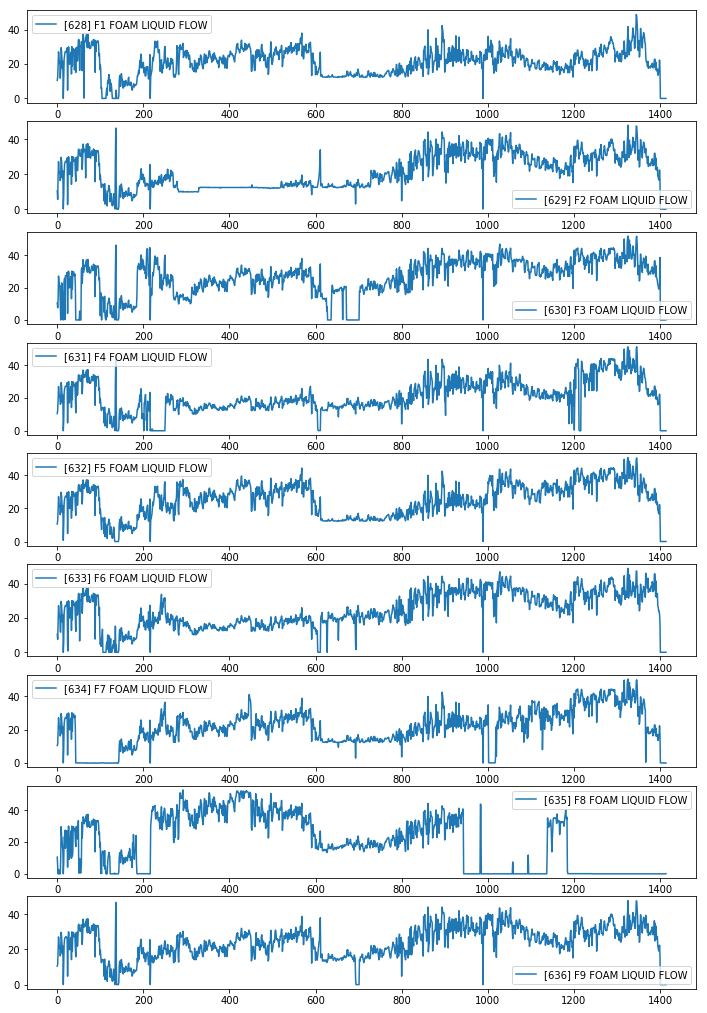

1

In [15]:
plot_multi_series(series_list,title_names=sample_keys_l)

In [16]:
corr_mat = compute_corr_matrix(series_list)
uncor_pair = find_uncorr_pair(corr_mat,thre=0.7)
# print (len(uncor_pair),uncor_pair)

In [17]:
db = DBSCAN(eps=0.3, min_samples=2,metric=corr_dist_lag0,n_jobs=-1).fit(series_list)

In [18]:
labels_g = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_g)) - (1 if -1 in labels else 0)
n_noise_ = list(labels_g).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 8


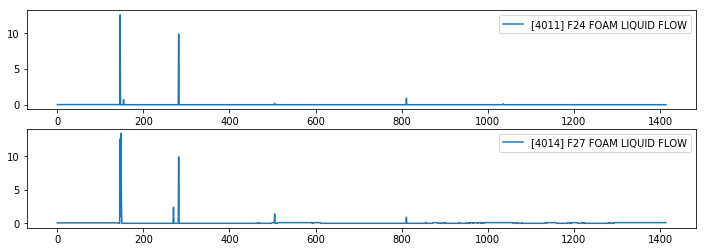

1

In [35]:
# visualization
cluster_idcs_list = list(np.where(labels_g==3)[0])
plot_multi_series(series_list,cluster_idcs_list,sample_keys_l)

## Cluster with correlation for the whole dataset

In [21]:
keys = valid_data_clean.keys()

data_list = []
for i,k in enumerate(keys):
    x = np.array(valid_data_clean[k][1:])
    data_list.append(x)

In [22]:
db = DBSCAN(eps=0.1, min_samples=2,metric=corr_dist_lag0,n_jobs=-1).fit(data_list)

../utils/computation.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return (np.dot(x0,y0)/l)/(np.std(x)*np.std(y))
../utils/computation.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return (np.dot(x0,y0)/l)/(np.std(x)*np.std(y))


In [23]:
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 421
Estimated number of noise points: 1899


In [ ]:
def extract_large_cluster(labels):
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
    # get attribute of clusters
    cluster_item_count = []
    for i in range(n_clusters_):
        cluster = np.array(keys)[labels==i]
        num_items = len(cluster)
        cluster_item_count.append(num_items)

    # select the large group as a sample
    num_thre = 20
    large_cluster_ids = [i for (i,n) in enumerate(cluster_item_count) if n>num_thre]
    

In [51]:
# get attribute of clusters
cluster_item_count = []
for i in range(n_clusters_):
    cluster = np.array(keys)[labels==i]
    num_items = len(cluster)
    cluster_item_count.append(num_items)
    
# select the large group as a sample
num_thre = 20
large_cluster_ids = [i for (i,n) in enumerate(cluster_item_count) if n>num_thre]
print (len(large_cluster_ids))
print (np.array(keys)[labels==large_cluster_ids[np.random.randint(len(large_cluster_ids))]])

20
['[4335] No.11 B Liquid Injection Pressure High Limit'
 '[4387] F2 Port Foam Injection Pressure High Limit'
 '[4388] F3 Port Foam Injection Pressure High Limit'
 '[4390] F5 Port Foam Injection Pressure High Limit'
 '[4391] F6 Port Foam Injection Pressure High Limit'
 '[4392] F7 Port Foam Injection Pressure High Limit'
 '[4394] F9 Port Foam Injection Pressure High Limit'
 '[4395] F10 Port Foam Injection Pressure High Limit'
 '[4397] F12 Port Foam Injection Pressure High Limit'
 '[4398] F13 Port Foam Injection Pressure High Limit'
 '[4399] F14 Port Foam Injection Pressure High Limit'
 '[4400] F15 Port Foam Injection Pressure High Limit'
 '[4403] F18 Port Foam Injection Pressure High Limit'
 '[4404] F19 Port Foam Injection Pressure High Limit'
 '[4406] F23 Port Foam Injection Pressure High Limit'
 '[4407] F24 Port Foam Injection Pressure High Limit'
 '[4408] F25 Port Foam Injection Pressure High Limit'
 '[4409] F26 Port Foam Injection Pressure High Limit'
 '[4410] F27 Port Foam Injecti

Index(['[4450] F1 Port Foam Air Injection Flow Setting',
       '[4451] F2 Port Foam Air Injection Flow Setting',
       '[4452] F3 Port Foam Air Injection Flow Setting',
       '[4453] F4 Port Foam Air Injection Flow Setting',
       '[4454] F5 Port Foam Air Injection Flow Setting',
       '[4455] F6 Port Foam Air Injection Flow Setting',
       '[4456] F7 Port Foam Air Injection Flow Setting',
       '[4458] F9 Port Foam Air Injection Flow Setting',
       '[4459] F10 Port Foam Air Injection Flow Setting',
       '[4460] F11 Port Foam Air Injection Flow Setting',
       '[4461] F12 Port Foam Air Injection Flow Setting',
       '[4462] F13 Port Foam Air Injection Flow Setting',
       '[4463] F14 Port Foam Air Injection Flow Setting',
       '[4464] F15 Port Foam Air Injection Flow Setting',
       '[4465] F16 Port Foam Air Injection Flow Setting',
       '[4467] F18 Port Foam Air Injection Flow Setting',
       '[4468] F19 Port Foam Air Injection Flow Setting',
       '[4469] F21 Por

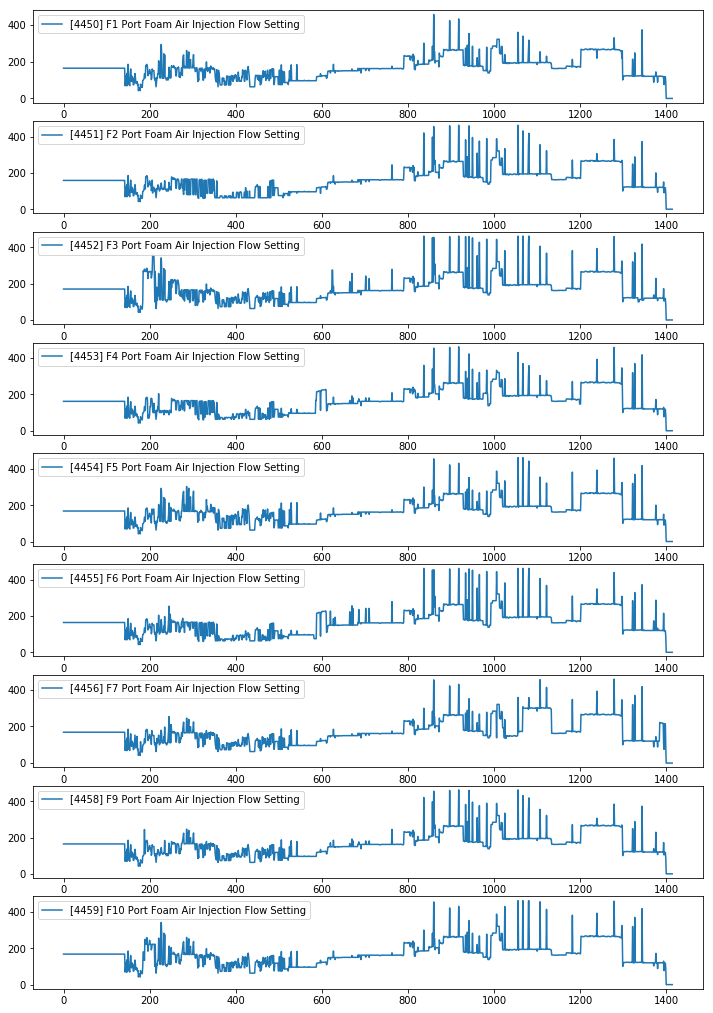

1

In [71]:
# visualization
cluster_idcs_list = list(np.where(labels==large_cluster_ids[16])[0])
cluster_keys = keys[cluster_idcs_list]
print (cluster_keys)
plot_multi_series(data_list,cluster_idcs_list,keys)